# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
import OpioidDataPrep as odp  #Custom functions for this project

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost #Tricky installation, see instructions (search for XGBoost)

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report, brier_score_loss, precision_score, 
                             recall_score, f1_score, log_loss, make_scorer)
from sklearn.model_selection import (learning_curve, validation_curve)


#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = True

print('Pandas Version', pd.__version__)
print('XGBoost Version', xgboost.__version__)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pandas Version 0.24.2
XGBoost Version 0.81


# 1. Load Data

This step loads the data from the file `features.pickle.zip`.

In [2]:
#Load Data
df = pd.read_pickle(dataDir+'features.pickle.zip')
df

,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BOOKED__GT1LTET2,...,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2
19,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0
20,0,0,0,0,0,0,0,1,-0.730225,1,...,0,0,0,0,0,1,0,1,0,0
21,1,0,0,1,0,0,0,0,-0.607937,1,...,0,0,0,0,1,0,0,0,0,0
23,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,1,0,0,0,0,0
33,1,0,0,1,0,0,0,0,-0.730225,0,...,0,0,0,1,0,0,0,0,0,0
34,1,0,0,1,0,0,0,0,-0.883085,1,...,1,0,1,0,0,0,1,1,0,0
36,1,0,0,0,0,0,0,0,2.174124,1,...,0,0,0,0,1,1,0,0,0,0
46,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,0,1,1,0,0,0
50,1,0,0,1,0,0,0,0,0.462087,0,...,0,0,0,0,1,0,0,0,0,0
52,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

In [3]:
#We'll first sort the data by column name, necessary to prevent errors later
#Specfically, calibrating with the cv='prefit' option fails without this sort
df = odp.sortDFbyColName(df)
df

,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BOOKED__GT1LTET2,...,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2
19,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0
20,0,0,0,0,0,0,0,1,-0.730225,1,...,0,0,0,0,0,1,0,1,0,0
21,1,0,0,1,0,0,0,0,-0.607937,1,...,0,0,0,0,1,0,0,0,0,0
23,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,1,0,0,0,0,0
33,1,0,0,1,0,0,0,0,-0.730225,0,...,0,0,0,1,0,0,0,0,0,0
34,1,0,0,1,0,0,0,0,-0.883085,1,...,1,0,1,0,0,0,1,1,0,0
36,1,0,0,0,0,0,0,0,2.174124,1,...,0,0,0,0,1,1,0,0,0,0
46,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,0,1,1,0,0,0
50,1,0,0,1,0,0,0,0,0.462087,0,...,0,0,0,0,1,0,0,0,0,0
52,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0


## 2.1 Split Features (X) and Outcome (Y)

In [4]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

    ADDPREV__GT1LTET2  ADDPREV__GT85LTET94  ADDPREV__GT94LTET97  \
19                  1                    0                    0   
20                  0                    0                    0   
21                  1                    0                    0   
23                  1                    0                    0   
33                  1                    0                    0   

    ADDSCEV__GT1LTET2  ADDSCEV__GT2LTET94  ADDSCEV__GT94LTET97  \
19                  0                   0                    0   
20                  0                   0                    0   
21                  1                   0                    0   
23                  1                   0                    0   
33                  1                   0                    0   

    ADDSCEV__GT97LTET98  ADDSCEV__GT98LTET99      AGE2  BOOKED__GT1LTET2  ...  \
19                    0                    1 -1.188806                 1  ...   
20                    0               

## 2.2 Split into Training, Validation, and Test

In [5]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(32014, 94)
(32014, 1)
(13340, 94)
(13340, 1)
(8004, 94)
(8004, 1)


In [6]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  53446
Number MISUSE==0 26723
Number MISUSE==1 26723
Proportion of MISUSE==0 in oversampled data is  0.5
Proportion of MISUSE==1 in oversampled data is  0.5
(32014, 94)
(32014, 1)
(53446, 94)
(53446, 1)
(13340, 94)
(13340, 1)
(8004, 94)
(8004, 1)


In [7]:
'''NO LONGER USING THIS, AND SAVING NUMPY FILES INSTEAD'''

#Save data files necessary for calculating feature importance, before conversion to numpy arrays
#valX.to_pickle(dataDir+'valX.pickle.zip')
#testX.to_pickle(dataDir+'testX.pickle.zip')
'''Note, the .to_pickle command INFERS zip compression based on the '.zip'
extension. Changing the extension will result in a HUGE file instead of a 
compressed file.
''';

## 2.3 Convert to Numpy

Next, we'll convert our data from pandas into numpy format, because several downstream components of the code / project don't work / work well with pandas, favoring the "numbers only" approach of numpy.  Specifically, this leads us to two tasks:

1. Convert data to numpy format.
2. Save column names for use later.

In [8]:
#Save column names to a pickle file
colNamesList = list(trainX.columns)

joblib.dump(colNamesList, dataDir+'colNamesList.zip')
    
'''To open in other files:
colNamesList = joblib.load(dataDir+'colNamesList.zip')
'''

#Convert dataframes to numpy arrays (do this AFTER saving column names)
trainX = trainX.values
trainY = trainY.values
valX = valX.values
valY = valY.values
testX = testX.values
testY = testY.values

#Save input data as numpy objects (for use in calculating feature importance, i.e., Shapley values)
np.save(arr=valX, file=dataDir+'valX.npy', allow_pickle=True)
np.save(arr=testX, file=dataDir+'testX.npy', allow_pickle=True)

# 3. Model Training

In this section we'll train a model.

Good article on validation loss: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

## 3.1 Logistic Regression

Train a logistic regression model

In [9]:
#Set and train a logistic regression model
modelLR = LogisticRegression()
modelLR.fit(trainX, trainY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[learning_curve] Training set sizes: [ 4275 13895 23515 33135 42756]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    3.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.8s finished
No handles with labels found to put in legend.


RED = Training Data
GREEN = Cross Validation Data


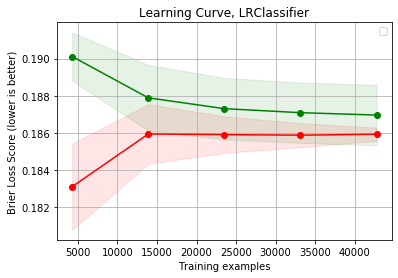

In [10]:
custScoreBrier = make_scorer(brier_score_loss, greater_is_better=True, needs_proba=True)

train_sizes, train_scores, test_scores = learning_curve(modelLR, trainX, trainY, n_jobs=-1, 
                                                        shuffle=True, verbose=2, cv=5, scoring=custScoreBrier)

#brier_score_loss

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

In [11]:
param_range=[5,10,15,20,25]

train_scores, test_scores = validation_curve(modelLR, trainX, trainY, 'max_iter', cv=5, n_jobs=-1, verbose=2,
                                              param_range=param_range, scoring=custScoreBrier)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    3.7s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.5s finished


No handles with labels found to put in legend.


[[0.18611574 0.18692378 0.186377   0.18622332 0.18675036]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]]
[[0.18956923 0.18532879 0.18798057 0.18798399 0.18606754]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]]
RED = Training Data
GREEN = Cross Validation Data


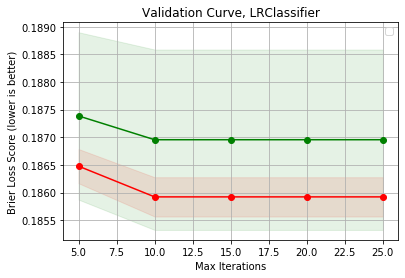

In [12]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.2 Extreme Gradient Boosting (XGBoost)

Train an XGBoost model.

In [13]:
#Custom Brier Scoring
def xg_Brier(y, t):
    t = t.get_label()
    return "Brier", brier_score_loss(t, y)

In [14]:
#Set and train the XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=630, n_jobs=-1,
                                booster='gbtree'
                                )

# MD=5 NE=300:  .11___
# MD=3 NE=630:  .1117

#LONG TIME STABLE MODEL
# modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=90, n_jobs=-1,
#                                 booster='gbtree'
#                                 )
'''Notes:
    1. n_jobs=-1 maximizes CPU utilization
    2. Beware running high max_depth and n_estimators; the shapley estimator in notebook 5
    crashes with high values ("The kernel appears to have died" with no error messages).'''
eval_set = [(trainX, trainY), (testX, testY)]
modelXGB.fit(trainX, trainY, eval_metric=xg_Brier, verbose=True, eval_set=eval_set) # eval_metric=['logloss'],

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.278075	validation_1-error:0.206022	validation_0-Brier:0.238031	validation_1-Brier:0.239479
[1]	validation_0-error:0.278075	validation_1-error:0.206022	validation_0-Brier:0.228367	validation_1-Brier:0.230884
[2]	validation_0-error:0.270928	validation_1-error:0.206022	validation_0-Brier:0.220438	validation_1-Brier:0.223738
[3]	validation_0-error:0.256764	validation_1-error:0.214768	validation_0-Brier:0.213521	validation_1-Brier:0.217164
[4]	validation_0-error:0.25465	validation_1-error:0.214768	validation_0-Brier:0.207758	validation_1-Brier:0.212052
[5]	validation_0-error:0.249523	validation_1-error:0.223013	validation_0-Brier:0.202702	validation_1-Brier:0.206987
[6]	validation_0-error:0.254949	validation_1-error:0.219265	validation_0-Brier:0.198193	validation_1-Brier:0.202886
[7]	validation_0-error:0.244041	validation_1-error:0.221264	validation_0-Brier:0.193774	validation_1-Brier:0.198783
[8]	validation_0-error:0.237417	validation_1-error:0.21989	validation_0-B

[71]	validation_0-error:0.145268	validation_1-error:0.168416	validation_0-Brier:0.112492	validation_1-Brier:0.133579
[72]	validation_0-error:0.14495	validation_1-error:0.168916	validation_0-Brier:0.112304	validation_1-Brier:0.133498
[73]	validation_0-error:0.144071	validation_1-error:0.167916	validation_0-Brier:0.111731	validation_1-Brier:0.133147
[74]	validation_0-error:0.14278	validation_1-error:0.167041	validation_0-Brier:0.110947	validation_1-Brier:0.132586
[75]	validation_0-error:0.142462	validation_1-error:0.166667	validation_0-Brier:0.110664	validation_1-Brier:0.132313
[76]	validation_0-error:0.142387	validation_1-error:0.166417	validation_0-Brier:0.110394	validation_1-Brier:0.132087
[77]	validation_0-error:0.141582	validation_1-error:0.165792	validation_0-Brier:0.109834	validation_1-Brier:0.131658
[78]	validation_0-error:0.141245	validation_1-error:0.166292	validation_0-Brier:0.109572	validation_1-Brier:0.131519
[79]	validation_0-error:0.141489	validation_1-error:0.166542	valid

[141]	validation_0-error:0.121749	validation_1-error:0.14905	validation_0-Brier:0.094341	validation_1-Brier:0.121297
[142]	validation_0-error:0.121337	validation_1-error:0.148926	validation_0-Brier:0.094146	validation_1-Brier:0.121167
[143]	validation_0-error:0.121525	validation_1-error:0.148926	validation_0-Brier:0.094084	validation_1-Brier:0.121175
[144]	validation_0-error:0.121206	validation_1-error:0.148551	validation_0-Brier:0.09402	validation_1-Brier:0.121146
[145]	validation_0-error:0.121075	validation_1-error:0.148926	validation_0-Brier:0.093961	validation_1-Brier:0.121132
[146]	validation_0-error:0.120888	validation_1-error:0.148426	validation_0-Brier:0.093749	validation_1-Brier:0.120955
[147]	validation_0-error:0.120795	validation_1-error:0.148176	validation_0-Brier:0.093546	validation_1-Brier:0.120857
[148]	validation_0-error:0.119841	validation_1-error:0.148426	validation_0-Brier:0.093186	validation_1-Brier:0.120628
[149]	validation_0-error:0.119859	validation_1-error:0.148

[211]	validation_0-error:0.111982	validation_1-error:0.143303	validation_0-Brier:0.085658	validation_1-Brier:0.115521
[212]	validation_0-error:0.111963	validation_1-error:0.143053	validation_0-Brier:0.085612	validation_1-Brier:0.115471
[213]	validation_0-error:0.111851	validation_1-error:0.143053	validation_0-Brier:0.08554	validation_1-Brier:0.115424
[214]	validation_0-error:0.111833	validation_1-error:0.143178	validation_0-Brier:0.085492	validation_1-Brier:0.115376
[215]	validation_0-error:0.111776	validation_1-error:0.143178	validation_0-Brier:0.085445	validation_1-Brier:0.115328
[216]	validation_0-error:0.111758	validation_1-error:0.143053	validation_0-Brier:0.085394	validation_1-Brier:0.115274
[217]	validation_0-error:0.111739	validation_1-error:0.143178	validation_0-Brier:0.085324	validation_1-Brier:0.115228
[218]	validation_0-error:0.111776	validation_1-error:0.142929	validation_0-Brier:0.085252	validation_1-Brier:0.11518
[219]	validation_0-error:0.11172	validation_1-error:0.1430

[281]	validation_0-error:0.106332	validation_1-error:0.140305	validation_0-Brier:0.081197	validation_1-Brier:0.112955
[282]	validation_0-error:0.106032	validation_1-error:0.140305	validation_0-Brier:0.081139	validation_1-Brier:0.112926
[283]	validation_0-error:0.105714	validation_1-error:0.140055	validation_0-Brier:0.081021	validation_1-Brier:0.112853
[284]	validation_0-error:0.105714	validation_1-error:0.14043	validation_0-Brier:0.080986	validation_1-Brier:0.112824
[285]	validation_0-error:0.105564	validation_1-error:0.140055	validation_0-Brier:0.080926	validation_1-Brier:0.112813
[286]	validation_0-error:0.105602	validation_1-error:0.140055	validation_0-Brier:0.08087	validation_1-Brier:0.112781
[287]	validation_0-error:0.105564	validation_1-error:0.14018	validation_0-Brier:0.080851	validation_1-Brier:0.112771
[288]	validation_0-error:0.105583	validation_1-error:0.14018	validation_0-Brier:0.080833	validation_1-Brier:0.112767
[289]	validation_0-error:0.105564	validation_1-error:0.14018

[351]	validation_0-error:0.102646	validation_1-error:0.13993	validation_0-Brier:0.078361	validation_1-Brier:0.111489
[352]	validation_0-error:0.102683	validation_1-error:0.13993	validation_0-Brier:0.078304	validation_1-Brier:0.111464
[353]	validation_0-error:0.102646	validation_1-error:0.13968	validation_0-Brier:0.07821	validation_1-Brier:0.111425
[354]	validation_0-error:0.102421	validation_1-error:0.13968	validation_0-Brier:0.078152	validation_1-Brier:0.111395
[355]	validation_0-error:0.102384	validation_1-error:0.13993	validation_0-Brier:0.078112	validation_1-Brier:0.111351
[356]	validation_0-error:0.102421	validation_1-error:0.13993	validation_0-Brier:0.078068	validation_1-Brier:0.111326
[357]	validation_0-error:0.102402	validation_1-error:0.139805	validation_0-Brier:0.078013	validation_1-Brier:0.111293
[358]	validation_0-error:0.10244	validation_1-error:0.13993	validation_0-Brier:0.077985	validation_1-Brier:0.111294
[359]	validation_0-error:0.102346	validation_1-error:0.139805	val

[421]	validation_0-error:0.100849	validation_1-error:0.139555	validation_0-Brier:0.076441	validation_1-Brier:0.110648
[422]	validation_0-error:0.100812	validation_1-error:0.13943	validation_0-Brier:0.076408	validation_1-Brier:0.110628
[423]	validation_0-error:0.100868	validation_1-error:0.13943	validation_0-Brier:0.076376	validation_1-Brier:0.110604
[424]	validation_0-error:0.100849	validation_1-error:0.139305	validation_0-Brier:0.076364	validation_1-Brier:0.110598
[425]	validation_0-error:0.100849	validation_1-error:0.139305	validation_0-Brier:0.076326	validation_1-Brier:0.110594
[426]	validation_0-error:0.100775	validation_1-error:0.139305	validation_0-Brier:0.076303	validation_1-Brier:0.11059
[427]	validation_0-error:0.1007	validation_1-error:0.13943	validation_0-Brier:0.076288	validation_1-Brier:0.110577
[428]	validation_0-error:0.100662	validation_1-error:0.139305	validation_0-Brier:0.076272	validation_1-Brier:0.110572
[429]	validation_0-error:0.100662	validation_1-error:0.13943	v

[491]	validation_0-error:0.099839	validation_1-error:0.13943	validation_0-Brier:0.075303	validation_1-Brier:0.110261
[492]	validation_0-error:0.099802	validation_1-error:0.13918	validation_0-Brier:0.075266	validation_1-Brier:0.110257
[493]	validation_0-error:0.099764	validation_1-error:0.13918	validation_0-Brier:0.075259	validation_1-Brier:0.110243
[494]	validation_0-error:0.099764	validation_1-error:0.13918	validation_0-Brier:0.075244	validation_1-Brier:0.110238
[495]	validation_0-error:0.099783	validation_1-error:0.13943	validation_0-Brier:0.075233	validation_1-Brier:0.110215
[496]	validation_0-error:0.09982	validation_1-error:0.13943	validation_0-Brier:0.075225	validation_1-Brier:0.110212
[497]	validation_0-error:0.099839	validation_1-error:0.13943	validation_0-Brier:0.075207	validation_1-Brier:0.110214
[498]	validation_0-error:0.09982	validation_1-error:0.13943	validation_0-Brier:0.075203	validation_1-Brier:0.11021
[499]	validation_0-error:0.09982	validation_1-error:0.13943	validat

[561]	validation_0-error:0.099166	validation_1-error:0.13918	validation_0-Brier:0.07436	validation_1-Brier:0.109944
[562]	validation_0-error:0.099147	validation_1-error:0.13918	validation_0-Brier:0.074345	validation_1-Brier:0.109937
[563]	validation_0-error:0.099166	validation_1-error:0.13918	validation_0-Brier:0.074339	validation_1-Brier:0.109952
[564]	validation_0-error:0.099184	validation_1-error:0.139305	validation_0-Brier:0.074333	validation_1-Brier:0.109937
[565]	validation_0-error:0.099166	validation_1-error:0.13918	validation_0-Brier:0.07433	validation_1-Brier:0.109935
[566]	validation_0-error:0.099184	validation_1-error:0.139305	validation_0-Brier:0.074321	validation_1-Brier:0.109925
[567]	validation_0-error:0.098978	validation_1-error:0.139055	validation_0-Brier:0.074306	validation_1-Brier:0.109901
[568]	validation_0-error:0.098941	validation_1-error:0.13918	validation_0-Brier:0.074296	validation_1-Brier:0.109898
[569]	validation_0-error:0.098941	validation_1-error:0.13918	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=630,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

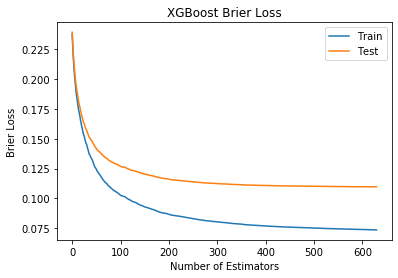

In [15]:
#Plot Log Loss Train vs. Test sets

results = modelXGB.evals_result()

epochs = len(results['validation_0']['Brier'])

x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['Brier'], label='Train')
ax.plot(x_axis, results['validation_1']['Brier'], label='Test')
ax.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Brier Loss')
plt.title('XGBoost Brier Loss')
plt.show()

In [16]:
#Build validation curve.  This cell takes ~1 min to run
runThis = False
if runThis:
    param_range=[25,50,75,100]
    
    train_scores, test_scores = validation_curve(modelXGB, trainX, trainY,
                                                 'n_estimators', cv=4, n_jobs=-1,
                                                 verbose=2, param_range=param_range,
                                                 scoring=custScoreBrier
                                                )

No handles with labels found to put in legend.


[[0.18611574 0.18692378 0.186377   0.18622332 0.18675036]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]
 [0.18539589 0.18642134 0.18583527 0.1857665  0.1861938 ]]
[[0.18956923 0.18532879 0.18798057 0.18798399 0.18606754]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]
 [0.18945546 0.1847677  0.18746991 0.1874528  0.1856337 ]]
RED = Training Data
GREEN = Cross Validation Data


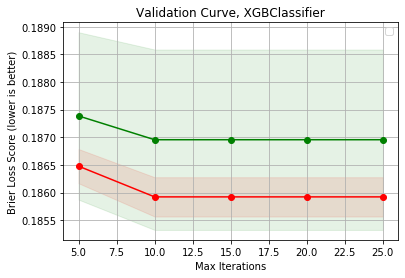

In [17]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, XGBClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.3 Neural Network

In [18]:
#Set and train NN classifier
modelNN = MLPClassifier(hidden_layer_sizes=(5, 5, 5), max_iter=200)
modelNN.fit(trainX, trainY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [19]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Confusion Matrix

In [20]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [21]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

## 4.3 ROC Curve

In [22]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn, trueY, predProbs):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=trueY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

## 4.4 Calibraiton Curve

In [23]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, 
                                             n_bins=20, strategy='quantile', normalize=False)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

## 4.5 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [24]:
def resultsSummary(preds, predProbs, trueY):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(trueY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=trueY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=trueY, y_score=predProbs)))
    print('Brier Score Loss:  {:.3}'.format(brier_score_loss(y_true=trueY, y_prob=predProbs)))
    print('  (Brier Score Loss evaluates probability estimates, lower is better)')

    #Descriptive Stats
    print('\nDESCRIPTIVE STATS ON PREDICTED PROBABILITIES:')
    print(pd.DataFrame({'Descriptive Stats':predProbs}).describe())
    
    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTED PROBABILITIES:')
    plt.hist(predProbs, bins=50)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(trueY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(trueY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr, trueY, predProbs)
    
    #Plot CalCurve
    pltCalCurve(trueY, predProbs)

## 4.6 Run Evaluations

### 4.6.1 Evaluate Logistic Regression Model

PREDICTION COUNTS:
 [[   0 9368]
 [   1 3972]]

ACCURACY SCORES:
Model Accuracy: 74.73%
Model ROC AUC:  77.07%
Brier Score Loss:  0.183
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.411054
std             0.224253
min             0.017610
25%             0.240495
50%             0.365228
75%             0.551139
max             0.996753

DISTRIBUTION OF PREDICTED PROBABILITIES:


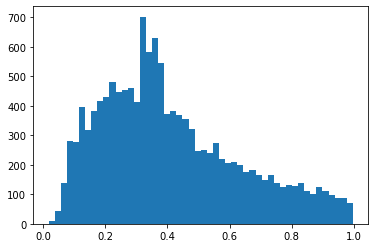


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     11229
           1       0.34      0.64      0.45      2111

    accuracy                           0.75     13340
   macro avg       0.63      0.70      0.64     13340
weighted avg       0.83      0.75      0.77     13340

CONFUSION MATRIX:


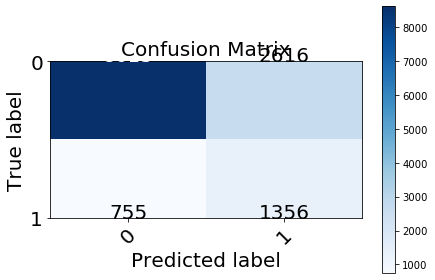

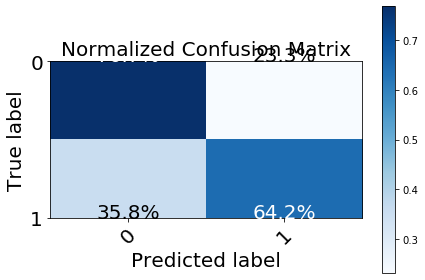

ROC CURVE:


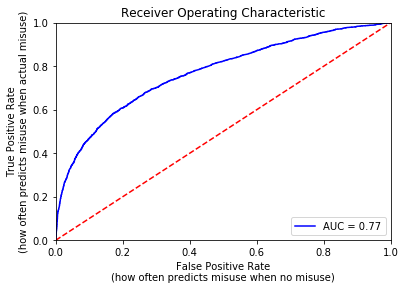

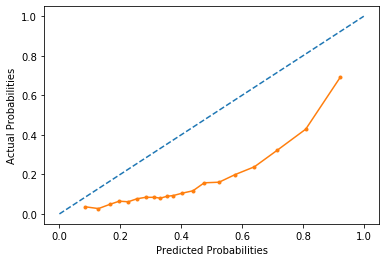

In [25]:
#Generate LR Predictions
predsLR = modelLR.predict(valX)
predProbsLR = modelLR.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelLRPredProbs.npy', arr=predProbsLR)

#Summarize
resultsSummary(predsLR, predProbsLR, valY)

### 4.6.2 Evaluate XGB Model

PREDICTION COUNTS:
 [[    0 12397]
 [    1   943]]

ACCURACY SCORES:
Model Accuracy: 86.18%
Model ROC AUC:  76.10%
Brier Score Loss:  0.111
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.191249
std             0.171231
min             0.003946
25%             0.073158
50%             0.136252
75%             0.252493
max             0.982025

DISTRIBUTION OF PREDICTED PROBABILITIES:


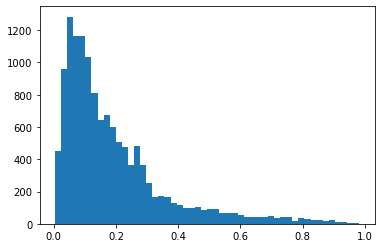


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     11229
           1       0.64      0.29      0.40      2111

    accuracy                           0.86     13340
   macro avg       0.76      0.63      0.66     13340
weighted avg       0.84      0.86      0.84     13340

CONFUSION MATRIX:


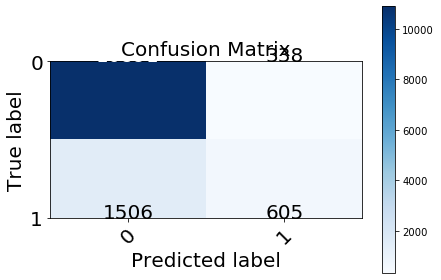

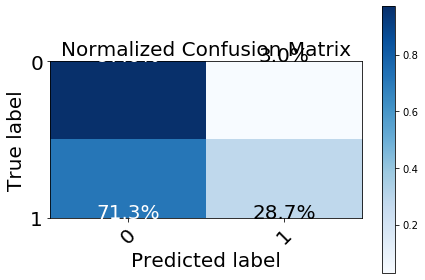

ROC CURVE:


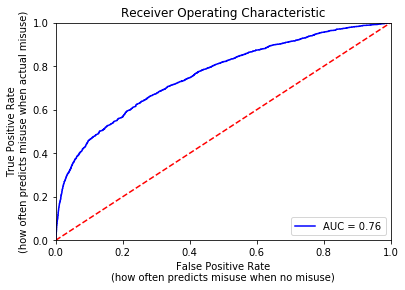

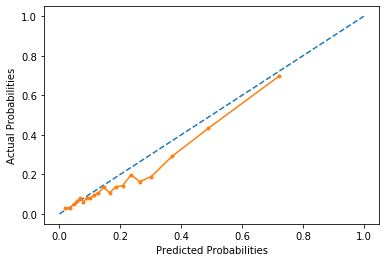

In [26]:
#Generate XGB Predictions
predsXGB = modelXGB.predict(valX)
predProbsXGB = modelXGB.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelXGBPredProbs.npy', arr=predProbsXGB)

#Summarize
resultsSummary(predsXGB, predProbsXGB, valY)

### 4.6.3 Evaluate Neural Network Model

PREDICTION COUNTS:
 [[    0 10097]
 [    1  3243]]

ACCURACY SCORES:
Model Accuracy: 77.74%
Model ROC AUC:  75.15%
Brier Score Loss:  0.162
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.349900
std             0.239784
min             0.007681
25%             0.169321
50%             0.249561
75%             0.488651
max             0.999027

DISTRIBUTION OF PREDICTED PROBABILITIES:


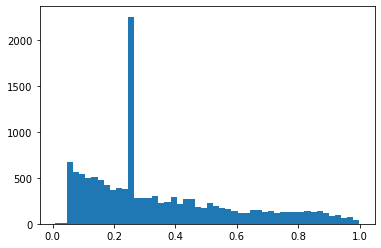


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     11229
           1       0.37      0.56      0.45      2111

    accuracy                           0.78     13340
   macro avg       0.64      0.69      0.65     13340
weighted avg       0.82      0.78      0.79     13340

CONFUSION MATRIX:


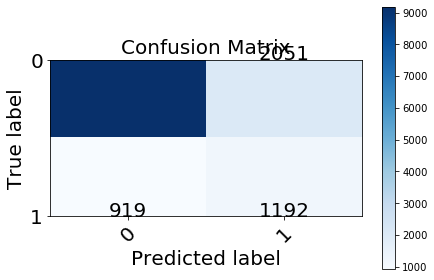

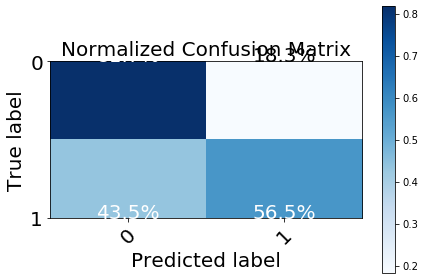

ROC CURVE:


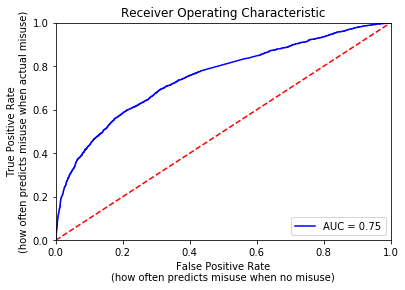

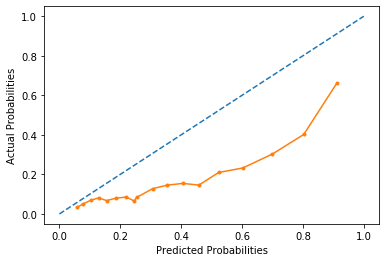

In [27]:
#Generate NN Predictions
predsNN = modelNN.predict(valX)
predProbsNN = modelNN.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelNNPredProbs.npy', arr=predProbsNN)

#Summarize
resultsSummary(predsNN, predProbsNN, valY)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

Note, we calibrate on the validation data (valX, valY), and then evaluate with `resultsSummary` on the test data (testY)

In [28]:
#Now we'll calibrate the model
runCalibration = True

## 5.1 Calibrate Logistic Regression Model

In [29]:
if runCalibration:
    calibratorLR = CalibratedClassifierCV(modelLR, cv='prefit', method='isotonic')
    calibratorLR.fit(valX, valY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7445]
 [   1  559]]

ACCURACY SCORES:
Model Accuracy: 86.38%
Model ROC AUC:  78.65%
Brier Score Loss:  0.106
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.162811
std             0.166236
min             0.000000
25%             0.071429
50%             0.094930
75%             0.161074
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


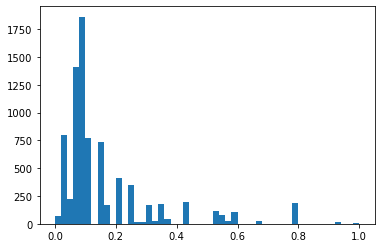


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6723
           1       0.67      0.29      0.41      1281

    accuracy                           0.86      8004
   macro avg       0.77      0.63      0.67      8004
weighted avg       0.85      0.86      0.84      8004

CONFUSION MATRIX:


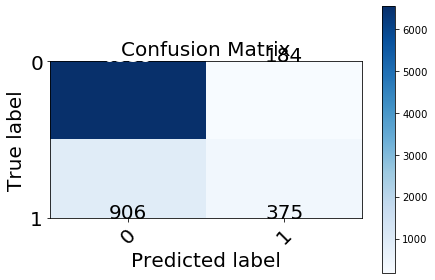

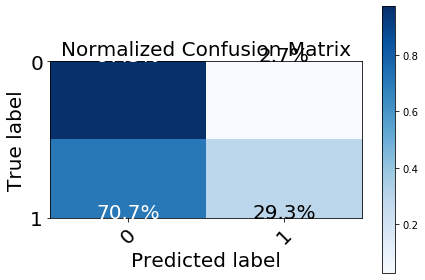

ROC CURVE:


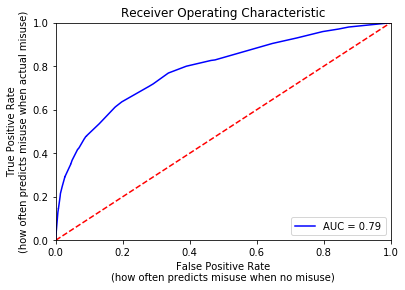

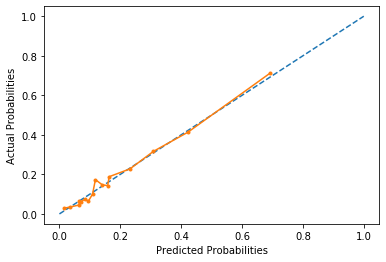

In [30]:
#Now recalculate predictions and print results
if runCalibration:
    predsLRCal = calibratorLR.predict(testX)
    predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
    resultsSummary(predsLRCal, predProbsLRCal, testY)
    
    np.save(file=dataDir+'modelLRCalPredProbs.npy', arr=predProbsLRCal)

## 5.2 Calibrate XGBoost Model

In [31]:
if runCalibration:
    calibratorXGB = CalibratedClassifierCV(modelXGB, method='sigmoid', cv='prefit')
    #cv='prefit' fails. Resorting the data didn't work.
    #Also, INCREASING TO cv=10 (FROM 3) GAVE A HUGE IMPROVEMENT.
    
    calibratorXGB.fit(valX, valY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7511]
 [   1  493]]

ACCURACY SCORES:
Model Accuracy: 86.13%
Model ROC AUC:  77.23%
Brier Score Loss:  0.108
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.160938
std             0.160090
min             0.049904
25%             0.071200
50%             0.097997
75%             0.173170
max             0.910173

DISTRIBUTION OF PREDICTED PROBABILITIES:


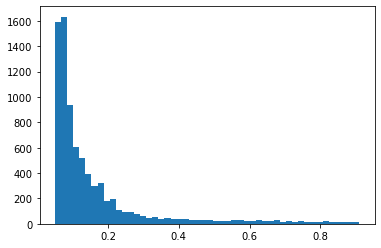


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6723
           1       0.67      0.26      0.37      1281

    accuracy                           0.86      8004
   macro avg       0.77      0.62      0.65      8004
weighted avg       0.84      0.86      0.83      8004

CONFUSION MATRIX:


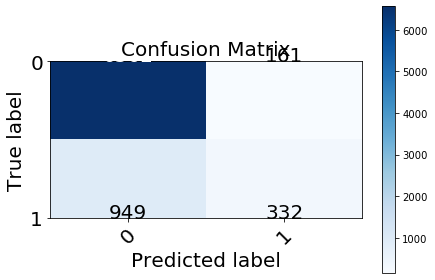

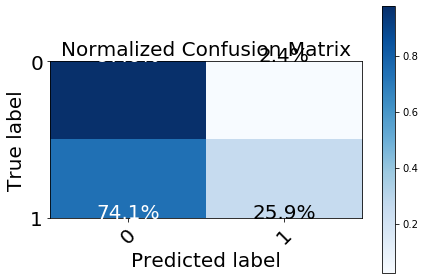

ROC CURVE:


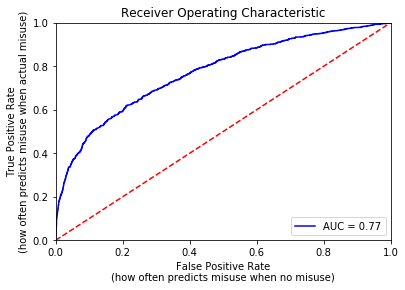

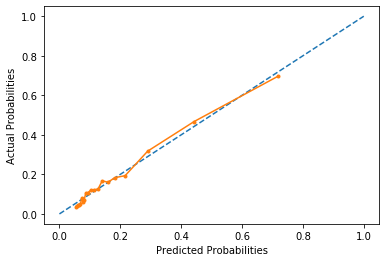

In [32]:
#Now recalculate predictions and print results
if runCalibration:
    predsXGBCal = calibratorXGB.predict(testX)
    predProbsXGBCal = calibratorXGB.predict_proba(testX)[:,1]
    resultsSummary(predsXGBCal, predProbsXGBCal, testY)
    
    np.save(file=dataDir+'modelXGBCalPredProbs.npy', arr=predProbsXGBCal)

## 5.3 Calibrate Neural Network Model

In [33]:
if runCalibration:
    calibratorNN = CalibratedClassifierCV(modelNN, method='isotonic', cv='prefit')    
    calibratorNN.fit(valX, valY)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7622]
 [   1  382]]

ACCURACY SCORES:
Model Accuracy: 85.77%
Model ROC AUC:  76.46%
Brier Score Loss:  0.111
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.162475
std             0.155975
min             0.000000
25%             0.074728
50%             0.078181
75%             0.222588
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


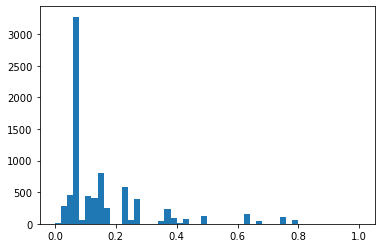


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6723
           1       0.69      0.20      0.32      1281

    accuracy                           0.86      8004
   macro avg       0.78      0.59      0.62      8004
weighted avg       0.84      0.86      0.82      8004

CONFUSION MATRIX:


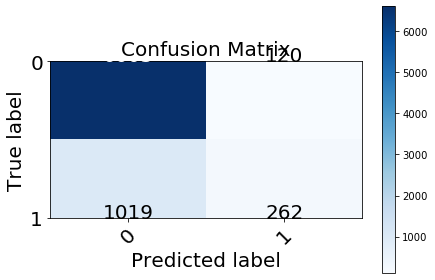

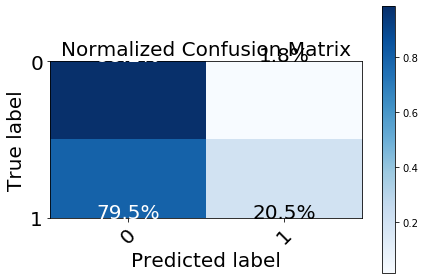

ROC CURVE:


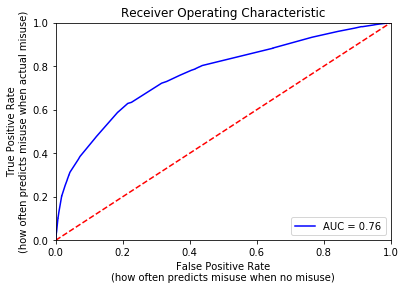

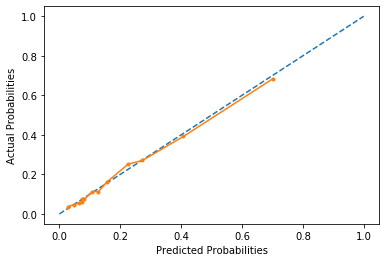

In [34]:
#Now recalculate predictions and print results
if runCalibration:
    predsNNCal = calibratorNN.predict(testX)
    predProbsNNCal = calibratorNN.predict_proba(testX)[:,1]
    resultsSummary(predsNNCal, predProbsNNCal, testY)
    
    np.save(file=dataDir+'modelNNCalPredProbs.npy', arr=predProbsNNCal)

# 6. Side By Side Model Comparisons

Here we'll look to compare results across all our models.

## 6.1 Side By Side Calibration Curves

Note these won't necessarily match the calibration curves ploted above because the ones in this section are calcualted on the test data, not the validation data. This strategy is correct because the calibrations themselves are generated from the validation data.

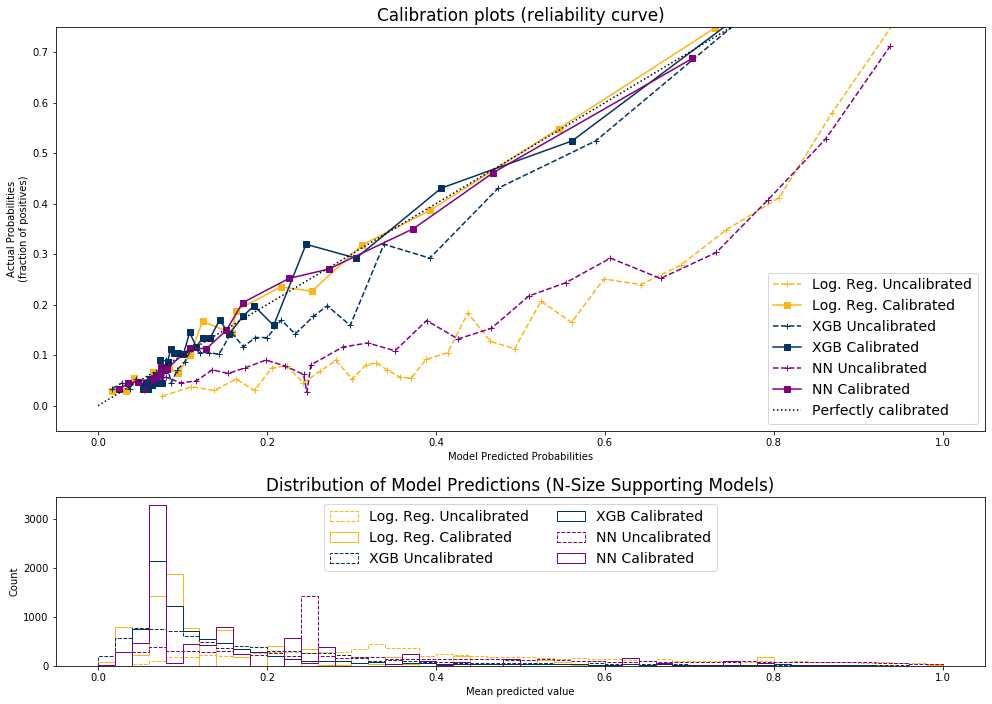

RESULTS TABLE, SORTED BY BRIER LOSS SCORE:


,Model,Brier Loss,Log Loss,ROC AUC,Precision,Recall,F1,Accuracy
0,Log. Reg. Calibrated,0.106031,0.361495,0.786469,0.670841,0.292740,0.407609,0.863818
0,XGB Calibrated,0.107831,0.360785,0.772256,0.673428,0.259173,0.374295,0.861319
0,XGB Uncalibrated,0.109805,0.366394,0.772256,0.642617,0.298985,0.408098,0.861194
0,NN Calibrated,0.110705,0.367280,0.764584,0.685864,0.204528,0.315093,0.857696
0,NN Uncalibrated,0.162543,0.502505,0.766206,0.374818,0.601874,0.461953,0.775612
0,Log. Reg. Uncalibrated,0.181870,0.549014,0.787738,0.354800,0.683841,0.467200,0.750375


In [35]:
#Initiate evaluation summary dataframe
dfEval = pd.DataFrame({'Model':[], 'Brier Loss':[], 'Log Loss':[], 'ROC AUC':[],
                       'Precision':[], 'Recall':[], 'F1':[], 'Accuracy':[]})

#Set up plots
fig = plt.figure(1, figsize=(14, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
plt.rcParams.update({'font.size': 14})  #Set global font size

#Iterate through each model: print it scores and plot its calibration curve
for clf, name, lineColor, lineStyle in \
    [(modelLR, 'Log. Reg. Uncalibrated', '#FDB515', '+--'),
     (calibratorLR,'Log. Reg. Calibrated', '#FDB515', 's-'),
     (modelXGB, 'XGB Uncalibrated', '#003262', '+--'),     
     (calibratorXGB,'XGB Calibrated', '#003262', 's-'),
     (modelNN, 'NN Uncalibrated', 'purple', '+--'),     
     (calibratorNN,'NN Calibrated', 'purple', 's-'),
    ]:

    #Generate predictions
    preds = clf.predict(testX)
    predProbs = clf.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data (strategy options are 'uniform' and 'quantile')
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=30, strategy='quantile', normalize=False)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, lineStyle, color=lineColor, label=name)
    
    #Plot histogram of probabilities (support)
    ax2.hist(predProbs, range=(0, 1), bins=50, label=name, color=lineColor, 
             linestyle=lineStyle[1:], histtype="step", lw=1)

    #Populate evaulation dataframe    
    dictNewRow = {'Model':[name],
                  'Brier Loss':[brier_score_loss(y_true=testY, y_prob=predProbs)], 
                  'Log Loss':[log_loss(y_true=testY, y_pred=predProbs)], 
                  'ROC AUC':[roc_auc_score(y_true=testY, y_score=predProbs)], 
                  'Precision':[precision_score(y_true=testY, y_pred=preds)], 
                  'Recall':[recall_score(y_true=testY, y_pred=preds)], 
                  'F1':[f1_score(y_true=testY, y_pred=preds)], 
                  'Accuracy':[accuracy_score(y_true=testY, y_pred=preds)]
                 }
    dfEval = pd.concat([dfEval, pd.DataFrame(dictNewRow)])


#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities\n(fraction of positives)")
ax1.set_ylim([-0.05, 0.75])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Distribution of Model Predictions (N-Size Supporting Models)')

zoomIn=False
if zoomIn:
    ax1.set_ylim([-0.00, 0.20])
    ax1.set_xlim([-0.00, 0.20])
    ax2.set_xlim([-0.00, 0.20])

plt.tight_layout()

plt.show() #Show plot
print('RESULTS TABLE, SORTED BY BRIER LOSS SCORE:')
dfEval.sort_values(by=['Brier Loss']) #Show eval

# 7. Compare Calibration Curves

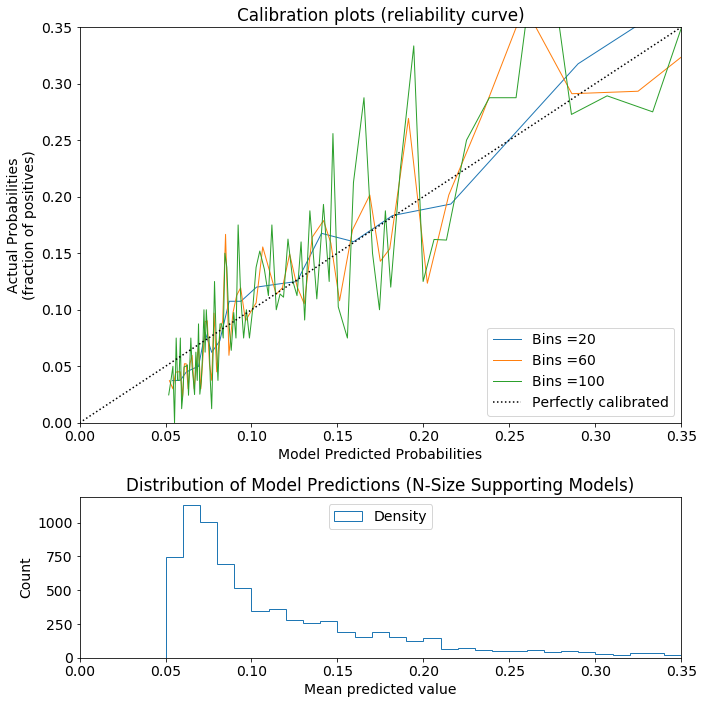

In [36]:
#Set up plots
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
plt.rcParams.update({'font.size': 14})  #Set global font size

#Iterate through each model: print it scores and plot its calibration curve
for numBins in range(20,110,40):

    #Generate predictions
    preds = calibratorXGB.predict(testX)
    predProbs = calibratorXGB.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data (strategy options are 'uniform' and 'quantile')
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=numBins, strategy='quantile', normalize=False)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, label='Bins ='+str(numBins), lw=1)
    
#Plot histogram of probabilities (support)
ax2.hist(predProbs, range=(0, 1), bins=100, label='Density',
         linestyle=lineStyle[1:], histtype="step", lw=1)

#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities\n(fraction of positives)")
ax1.set_ylim([-0.05, 0.75])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Distribution of Model Predictions (N-Size Supporting Models)')

zoomIn=True
if zoomIn:
    ax1.set_ylim([-0.00, 0.35])
    ax1.set_xlim([-0.00, 0.35])
    ax2.set_xlim([-0.00, 0.35])

plt.tight_layout()

plt.show() #Show plot

## 7.1 Quantifying Probability Accuracy

For our best model (calibrated XGB), we now seek to answer the question, how far off are the actual vs. predicted probabiltiies

In [44]:
#Generate probability scores

numBins = 30
    
preds = calibratorXGB.predict(testX)
predProbs = calibratorXGB.predict_proba(testX)[:, 1]

#Generate calibration curve data (strategy options are 'uniform' and 'quantile')
prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                         n_bins=numBins, strategy='quantile', normalize=False)

dfCalPreds = pd.DataFrame({'Predictions':prob_pred, 
                           'Actual':prob_true,
                           'Difference':prob_true - prob_pred,
                          })
dfCalPreds

,Predictions,Actual,Difference
0,0.053277,0.033708,-0.019569
1,0.056593,0.044944,-0.011649
2,0.059242,0.033835,-0.025408
3,0.061507,0.052239,-0.009269
4,0.063725,0.041353,-0.022372
5,0.066062,0.044944,-0.021118
6,0.068564,0.059925,-0.008639
7,0.071198,0.045113,-0.026085
8,0.073651,0.089888,0.016237
9,0.076201,0.044944,-0.031257


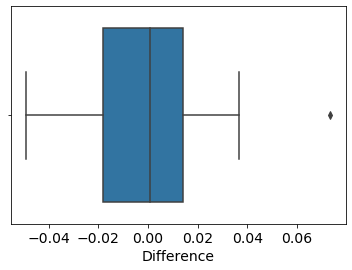

In [46]:
sns.boxplot(dfCalPreds['Difference'])

The plot above shows that 75% of the predictions are within +/- 2% points of their actual value, and all but one value are between -4% points and +5% points.  That one value is +7% points.

# 8. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [38]:
#Save model and any other necessary files
joblib.dump(modelLR, dataDir+'modelLR.model')
joblib.dump(modelXGB, dataDir+'modelXGB.model')
joblib.dump(modelNN, dataDir+'modelNN.model')

if runCalibration:
    joblib.dump(calibratorLR, dataDir+'calibLR.model')
    joblib.dump(calibratorXGB, dataDir+'calibXGB.model')
    joblib.dump(calibratorNN, dataDir+'calibNN.model')